In [1]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png"))
options(jupyter.plot_scale = 1.5)
require("pacman")
pacman::p_load(tidyverse, lubridate, zoo, ggpubr, ggfortify, forecast)

source('../Scripts/ReadData.R')
source('../Scripts/ModelSelection.R')
source('../Scripts/ResidualAnalysis.R')
source('../Scripts/Forecasting.R')

Loading required package: pacman



In [2]:
homeownership <- read_homeownership()

train <- head(homeownership, -4)
test <- tail(homeownership, 4)
arima_fit <- fit_arima(training_data = train$Value, p_range = 0:5, d_range = 0:2, q_range = 0:5)
head(arima_fit)

,p,d,q,AICC
,<int>,<int>,<int>,<dbl>
1,4,1,4,84.58706
2,5,2,5,91.42805
3,5,2,1,92.86359
4,3,1,3,93.41243
5,5,1,2,93.63021
6,2,1,2,93.79914



	Box-Ljung test

data:  residuals(model)
X-squared = 1.7212, df = 1, p-value = 0.1895


	Box-Ljung test

data:  residuals(model)^2
X-squared = 3.4489, df = 1, p-value = 0.06329



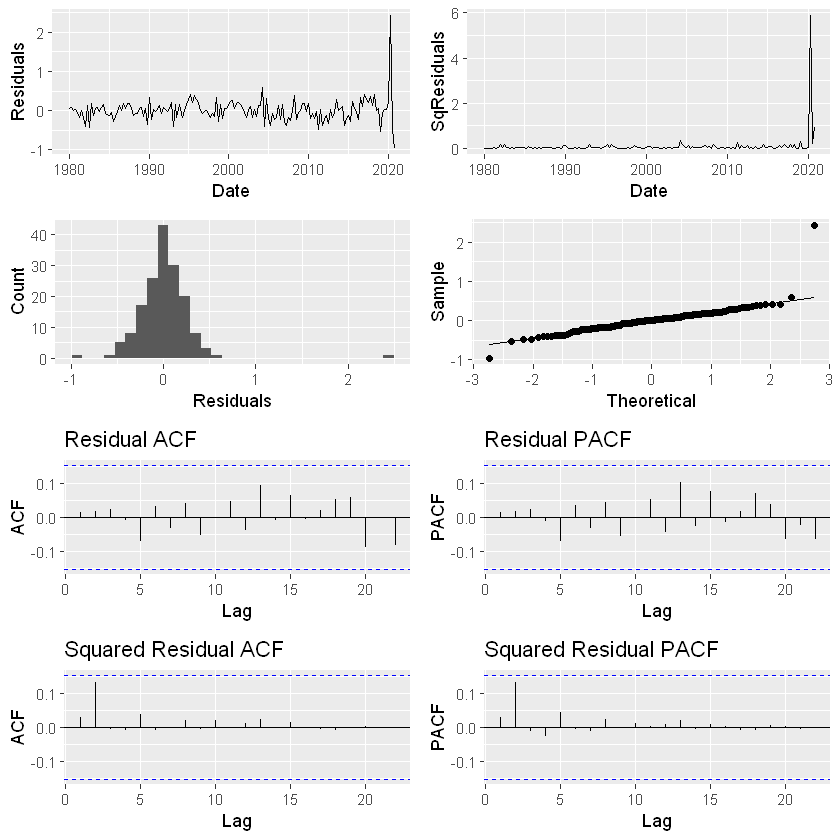

In [3]:
arima_model <- arima(train$Value, order = c(4,1,4), method = "ML")
residual_analysis(arima_model, train$Date)
box_tests(arima_model, 8)

In [4]:
arma_garch_fit <- fit_ugarch(train$Value, 4, 4, 0:5, 0:5, 0:2, 0:2)
head(arma_garch_fit$Final)

,p,q,m,n,BIC
,<int>,<int>,<int>,<int>,<dbl>
1,4,3,0,1,-0.2646367
2,4,3,0,2,-0.2351875
3,4,3,1,1,-0.1801362
4,4,3,2,0,-0.1772413
5,4,3,1,2,-0.1457759
6,4,3,2,1,-0.1351063



	Box-Ljung test

data:  residuals(model)
X-squared = 26.37, df = 1, p-value = 2.819e-07


	Box-Ljung test

data:  residuals(model)^2
X-squared = 38.922, df = 1, p-value = 4.41e-10



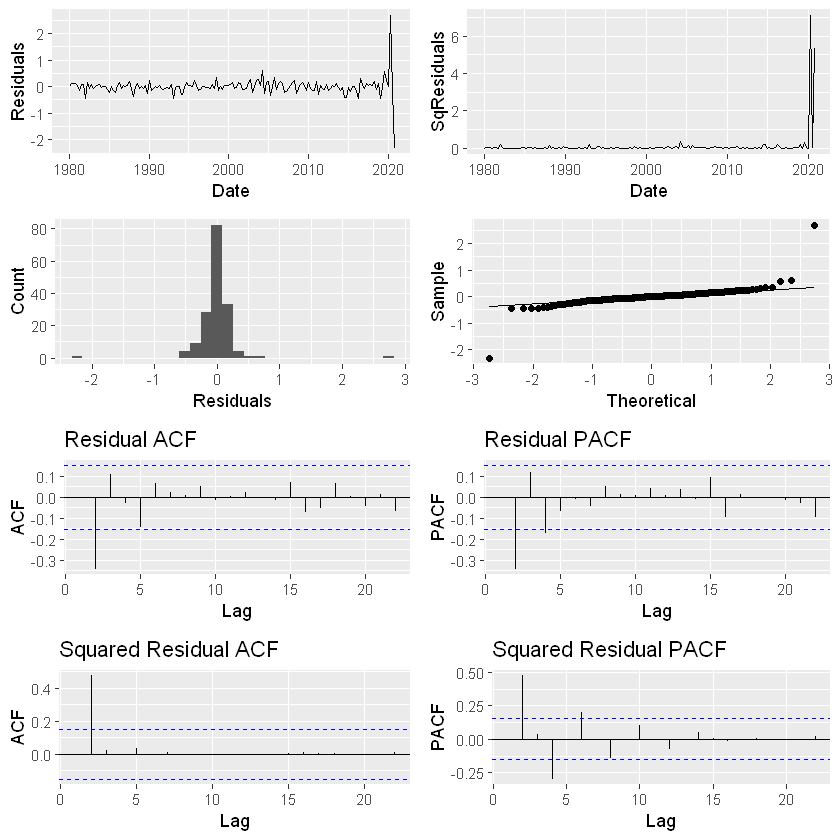

In [5]:
spec <- ugarchspec(variance.model=list(garchOrder=c(0,1)),
                     mean.model=list(armaOrder=c(4,3),
                                     include.mean=T), distribution.model="std")
suppressWarnings(ugarch_model1 <- ugarchfit(spec, train$Value, solver = 'hybrid'))
residual_analysis(ugarch_model1, train$Date)
box_tests(ugarch_model1, 8)


	Box-Ljung test

data:  residuals(model)
X-squared = 9.8095, df = 1, p-value = 0.001736


	Box-Ljung test

data:  residuals(model)^2
X-squared = 11.278, df = 1, p-value = 0.0007844



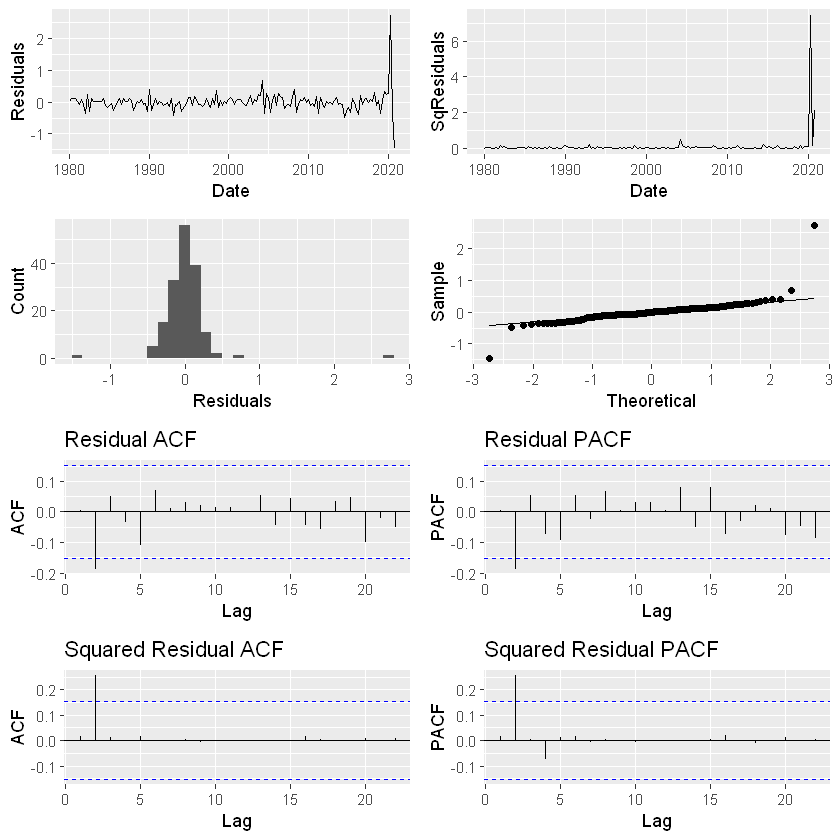

In [6]:
spec <- ugarchspec(variance.model=list(garchOrder=c(2,0)),
                     mean.model=list(armaOrder=c(4,3),
                                     include.mean=T), distribution.model="std")
suppressWarnings(ugarch_model2 <- ugarchfit(spec, train$Value, solver = 'hybrid'))
residual_analysis(ugarch_model2, train$Date)
box_tests(ugarch_model2, 9)


	Box-Ljung test

data:  residuals(model)
X-squared = 9.9734, df = 1, p-value = 0.001588


	Box-Ljung test

data:  residuals(model)^2
X-squared = 13.417, df = 1, p-value = 0.0002493



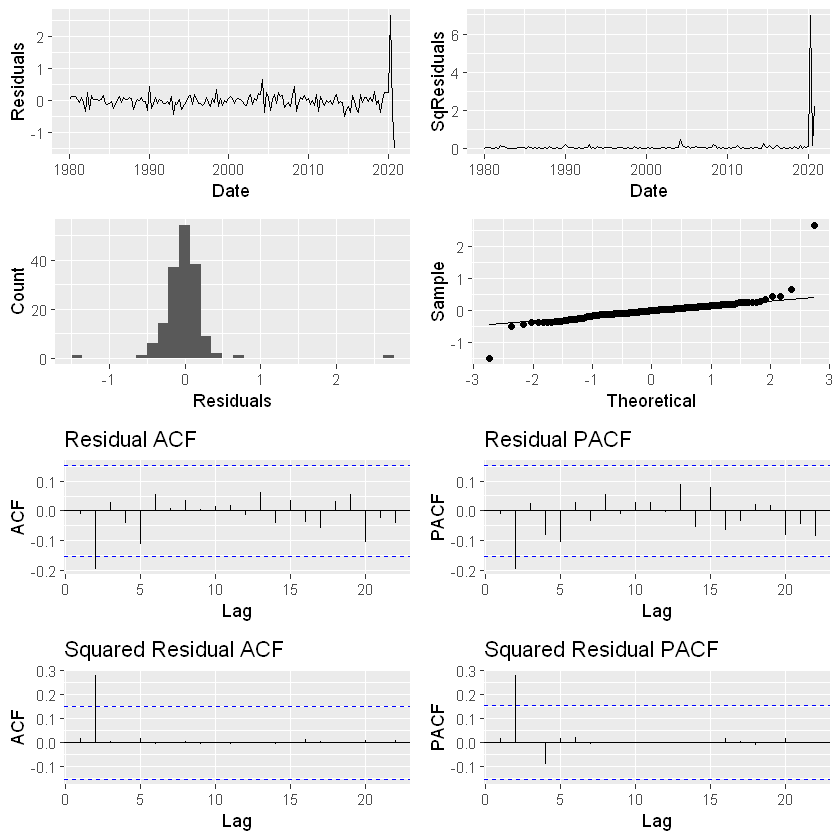

In [7]:
spec <- ugarchspec(variance.model=list(garchOrder=c(1,1)),
                     mean.model=list(armaOrder=c(4,3),
                                     include.mean=T), distribution.model="std")
suppressWarnings(ugarch_model3 <- ugarchfit(spec, train$Value, solver = 'hybrid'))
residual_analysis(ugarch_model3, train$Date)
box_tests(ugarch_model3, 12)

PM =  231.539

,ME,RMSE,MAE,MPE,MAPE
Test set,-1.474615,1.521641,1.474615,-2.251603,2.251603


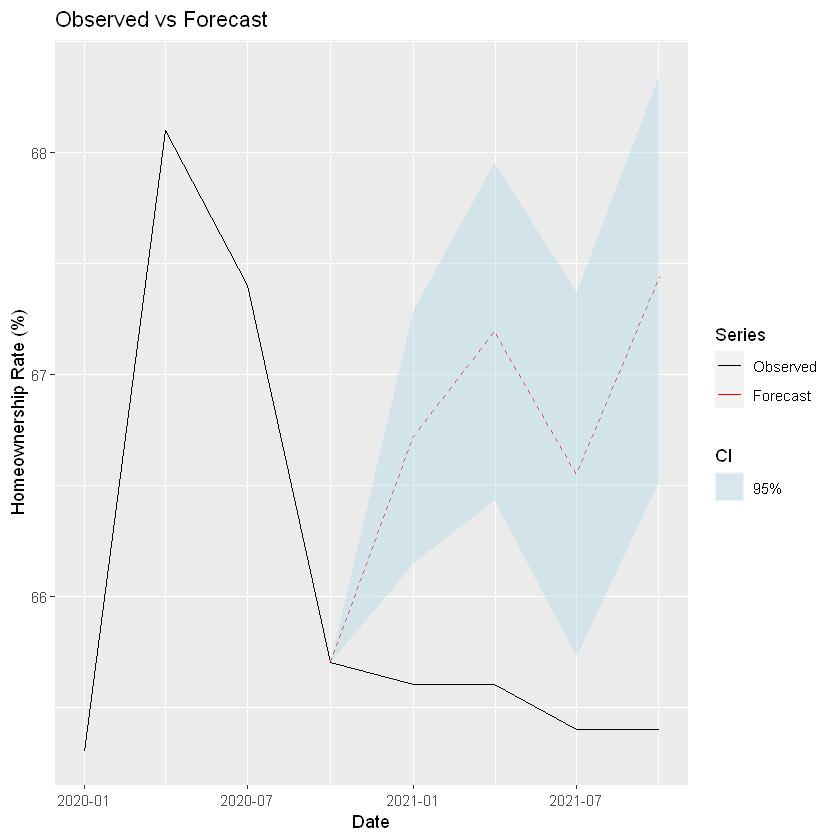

In [4]:
fc <- forecast_arima(arima_model, homeownership$Date, test$Value, 4, 95,
                    y_lab = "Homeownership Rate (%)")
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  15.54768

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.0446324,0.3943055,0.3483532,-0.06843127,0.5315374


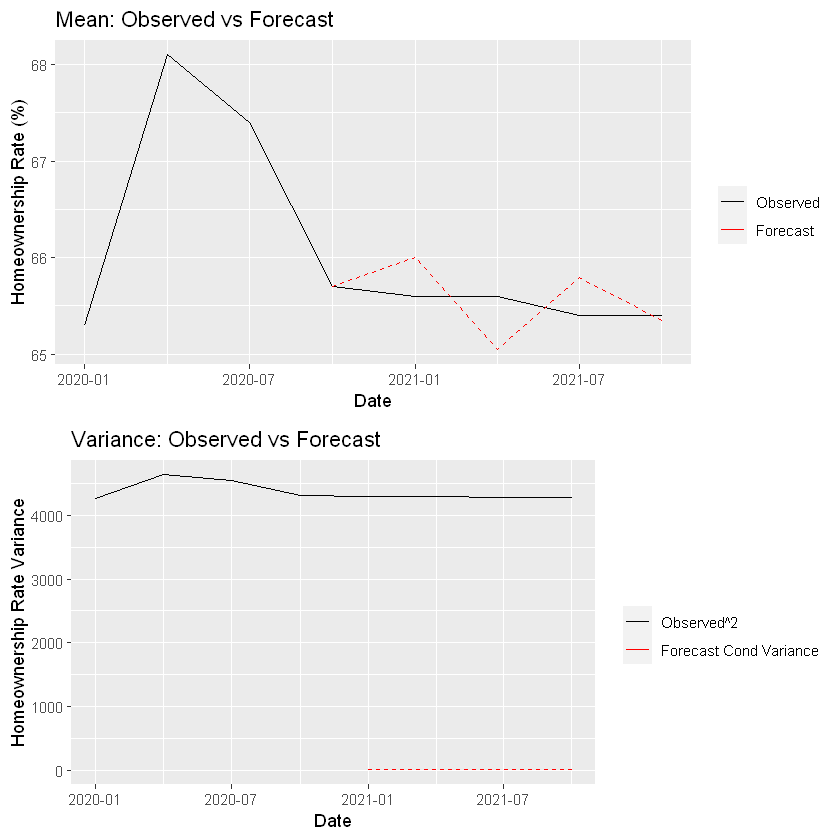

In [9]:
source('../Scripts/Forecasting.R')
fc <- forecast_ugarchroll(ugarch_model1, homeownership$Date, test$Value, 4,
                          y_lab = c("Homeownership Rate (%)", "Homeownership Rate Variance"))
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  17.55767

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.01075275,0.4190187,0.3622581,-0.01708236,0.5529137


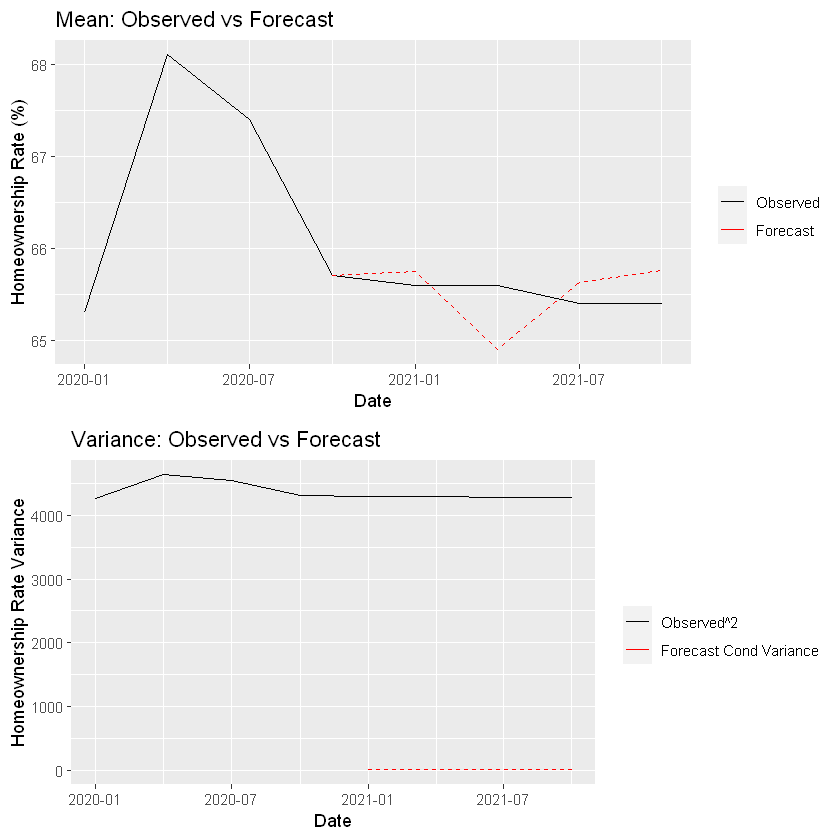

In [10]:
fc <- forecast_ugarchroll(ugarch_model2, homeownership$Date, test$Value, 4,
                          y_lab = c("Homeownership Rate (%)", "Homeownership Rate Variance"))
fc$plot
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)

PM =  118.9615

,ME,RMSE,MAE,MPE,MAPE
Test set,-0.6485676,1.090695,0.665283,-0.9913819,1.016863


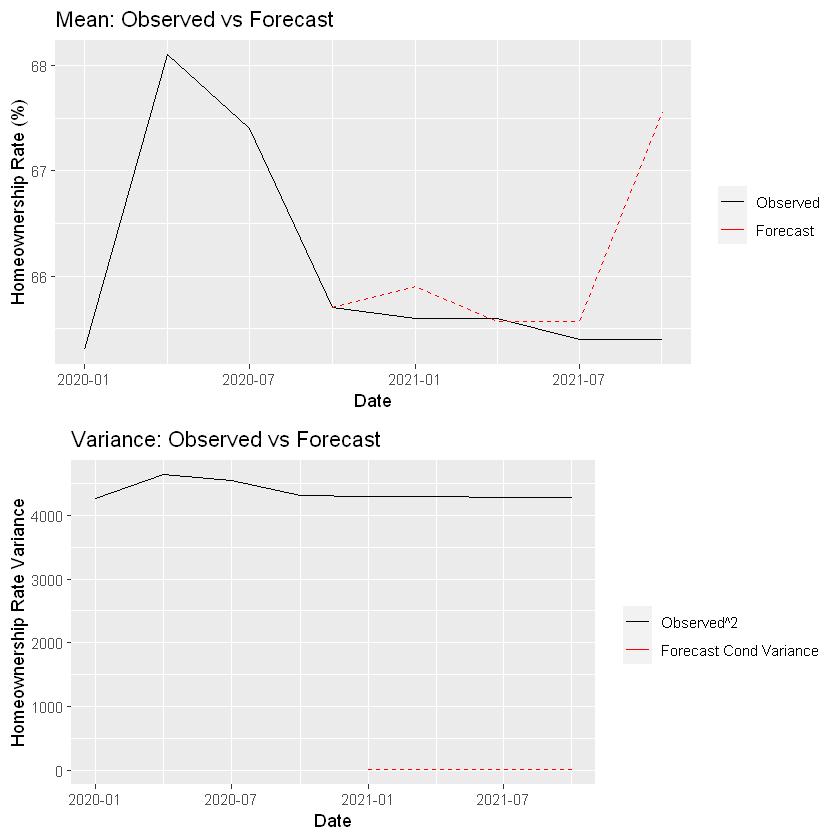

In [11]:
fc <- forecast_ugarchroll(ugarch_model3, homeownership$Date, test$Value, 4,
                          y_lab = c("Homeownership Rate (%)", "Homeownership Rate Variance"))
fc$plo
fc_data <- tail(fc$data, 4)
cat("PM = ", prec_measure(fc_data$Observed, fc_data$Forecast))
accuracy(fc_data$Forecast, x = fc_data$Observed)